In [44]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import missingno as msno

from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold
from sklearn.model_selection import GridSearchCV, cross_val_score, cross_validate, train_test_split as tts, KFold
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score

from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier

In [45]:
import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_columns', None)
pd.set_option('display.width', 500)

In [46]:
df = pd.read_csv("./german_credit_data 2.csv", index_col=0)
df.head()

,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose,Risk
0,67,male,2,own,NaN,little,1169,6,radio/TV,good
1,22,female,2,own,little,moderate,5951,48,radio/TV,bad
2,49,male,1,own,little,NaN,2096,12,education,good
3,45,male,2,free,little,little,7882,42,furniture/equipment,good
4,53,male,2,free,little,little,4870,24,car,bad


In [47]:
# Check Dataset:

def check_data(dataframe,head=5):
    print(20*"-" + "Information".center(20) + 20*"-")
    print(dataframe.info())
    print(20*"-" + "Data Shape".center(20) + 20*"-")
    print(dataframe.shape)
    print("\n" + 20*"-" + "The First 5 Data".center(20) + 20*"-")
    print(dataframe.head())
    print("\n" + 20 * "-" + "The Last 5 Data".center(20) + 20 * "-")
    print(dataframe.tail())
    print("\n" + 20 * "-" + "Missing Values".center(20) + 20 * "-")
    print(dataframe.isnull().sum())
    print("\n" + 40 * "-" + "Describe the Data".center(40) + 40 * "-")
    print(dataframe.describe().T)
check_data(df)

--------------------    Information     --------------------
<class 'pandas.core.frame.DataFrame'>
Int64Index: 1000 entries, 0 to 999
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Age               1000 non-null   int64 
 1   Sex               1000 non-null   object
 2   Job               1000 non-null   int64 
 3   Housing           1000 non-null   object
 4   Saving accounts   817 non-null    object
 5   Checking account  606 non-null    object
 6   Credit amount     1000 non-null   int64 
 7   Duration          1000 non-null   int64 
 8   Purpose           1000 non-null   object
 9   Risk              1000 non-null   object
dtypes: int64(4), object(6)
memory usage: 85.9+ KB
None
--------------------     Data Shape     --------------------
(1000, 10)

--------------------  The First 5 Data  --------------------
   Age     Sex  Job Housing Saving accounts Checking account  Credit amount  Duration      

In [48]:
# Check for duplicate rows
duplicated = df[df.duplicated()]

print('Before dropping duplicates:', df.shape[0])
print('Number of duplicate rows:', len(duplicated))

# Check if duplicates have any missing values
dup_nan = duplicated.isnull().sum().sum() == 0
if dup_nan:
    print('No missing values in duplicated rows')
else:
    print('Missing values in duplicated rows')

# Drop duplicates
df.drop_duplicates(inplace=True)
print('After dropping duplicates:', df.shape[0])

Before dropping duplicates: 1000
Number of duplicate rows: 0
No missing values in duplicated rows
After dropping duplicates: 1000


In [49]:
def unique_value(data_set, column_name):
    return data_set[column_name].nunique()

print("Number of the Unique Values:\n",unique_value(df, df.columns))   

Number of the Unique Values:
 Age                  53
Sex                   2
Job                   4
Housing               3
Saving accounts       4
Checking account      3
Credit amount       921
Duration             33
Purpose               8
Risk                  2
dtype: int64


In [50]:
def grab_col_names(dataframe, cat_th=5, car_th=20):
    # cat_cols, cat_but_car
    cat_cols = [col for col in dataframe.columns if dataframe[col].dtypes == "O"]

    num_but_cat = [col for col in dataframe.columns if dataframe[col].nunique() < cat_th and
                   dataframe[col].dtypes != "O"]
    cat_but_car = [col for col in dataframe.columns if dataframe[col].nunique() > car_th and
                   dataframe[col].dtypes == "O"]
    cat_cols = cat_cols + num_but_cat
    cat_cols = [col for col in cat_cols if col not in cat_but_car]

    # num_cols
    num_cols = [col for col in dataframe.columns if dataframe[col].dtypes != "O"]
    num_cols = [col for col in num_cols if col not in num_but_cat]

    print(f"Observations: {dataframe.shape[0]}")
    print(f"Variables: {dataframe.shape[1]}")
    print(f'cat_cols: {len(cat_cols)}')
    print(f'num_cols: {len(num_cols)}')
    print(f'cat_but_car: {len(cat_but_car)}')
    print(f'num_but_cat: {len(num_but_cat)}')
    return cat_cols, num_cols, cat_but_car

cat_cols, num_cols, cat_but_car = grab_col_names(df)

Observations: 1000
Variables: 10
cat_cols: 7
num_cols: 3
cat_but_car: 0
num_but_cat: 1


In [51]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Age,1000.0,35.546,11.375469,19.0,27.0,33.0,42.00,75.0
Job,1000.0,1.904,0.653614,0.0,2.0,2.0,2.00,3.0
Credit amount,1000.0,3271.258,2822.736876,250.0,1365.5,2319.5,3972.25,18424.0
Duration,1000.0,20.903,12.058814,4.0,12.0,18.0,24.00,72.0


Target Variable Analysis¶


In [52]:
df["Risk"].value_counts()

good    700
bad     300
Name: Risk, dtype: int64

      Risk  Ratio
good   700   70.0
bad    300   30.0


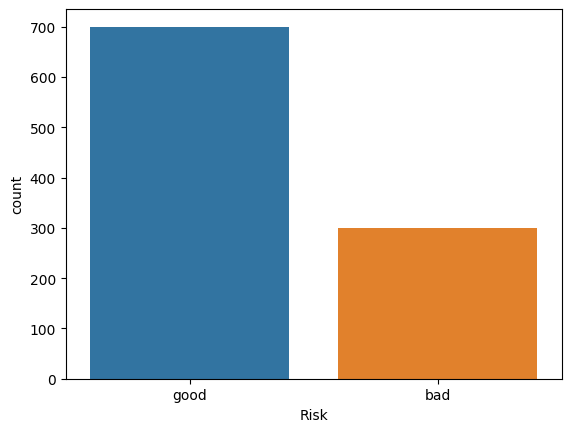

In [53]:
def cat_summary(dataframe, col_name, plot=False):
    print(pd.DataFrame({col_name: dataframe[col_name].value_counts(),
                        'Ratio': round(100 * (dataframe[col_name].value_counts()) / len(dataframe), 2)}))

    if plot:
        sns.countplot(x=col_name, data=dataframe)
        plt.show()
        
cat_summary(df, 'Risk', plot=True)

Missing Values¶


<AxesSubplot:>

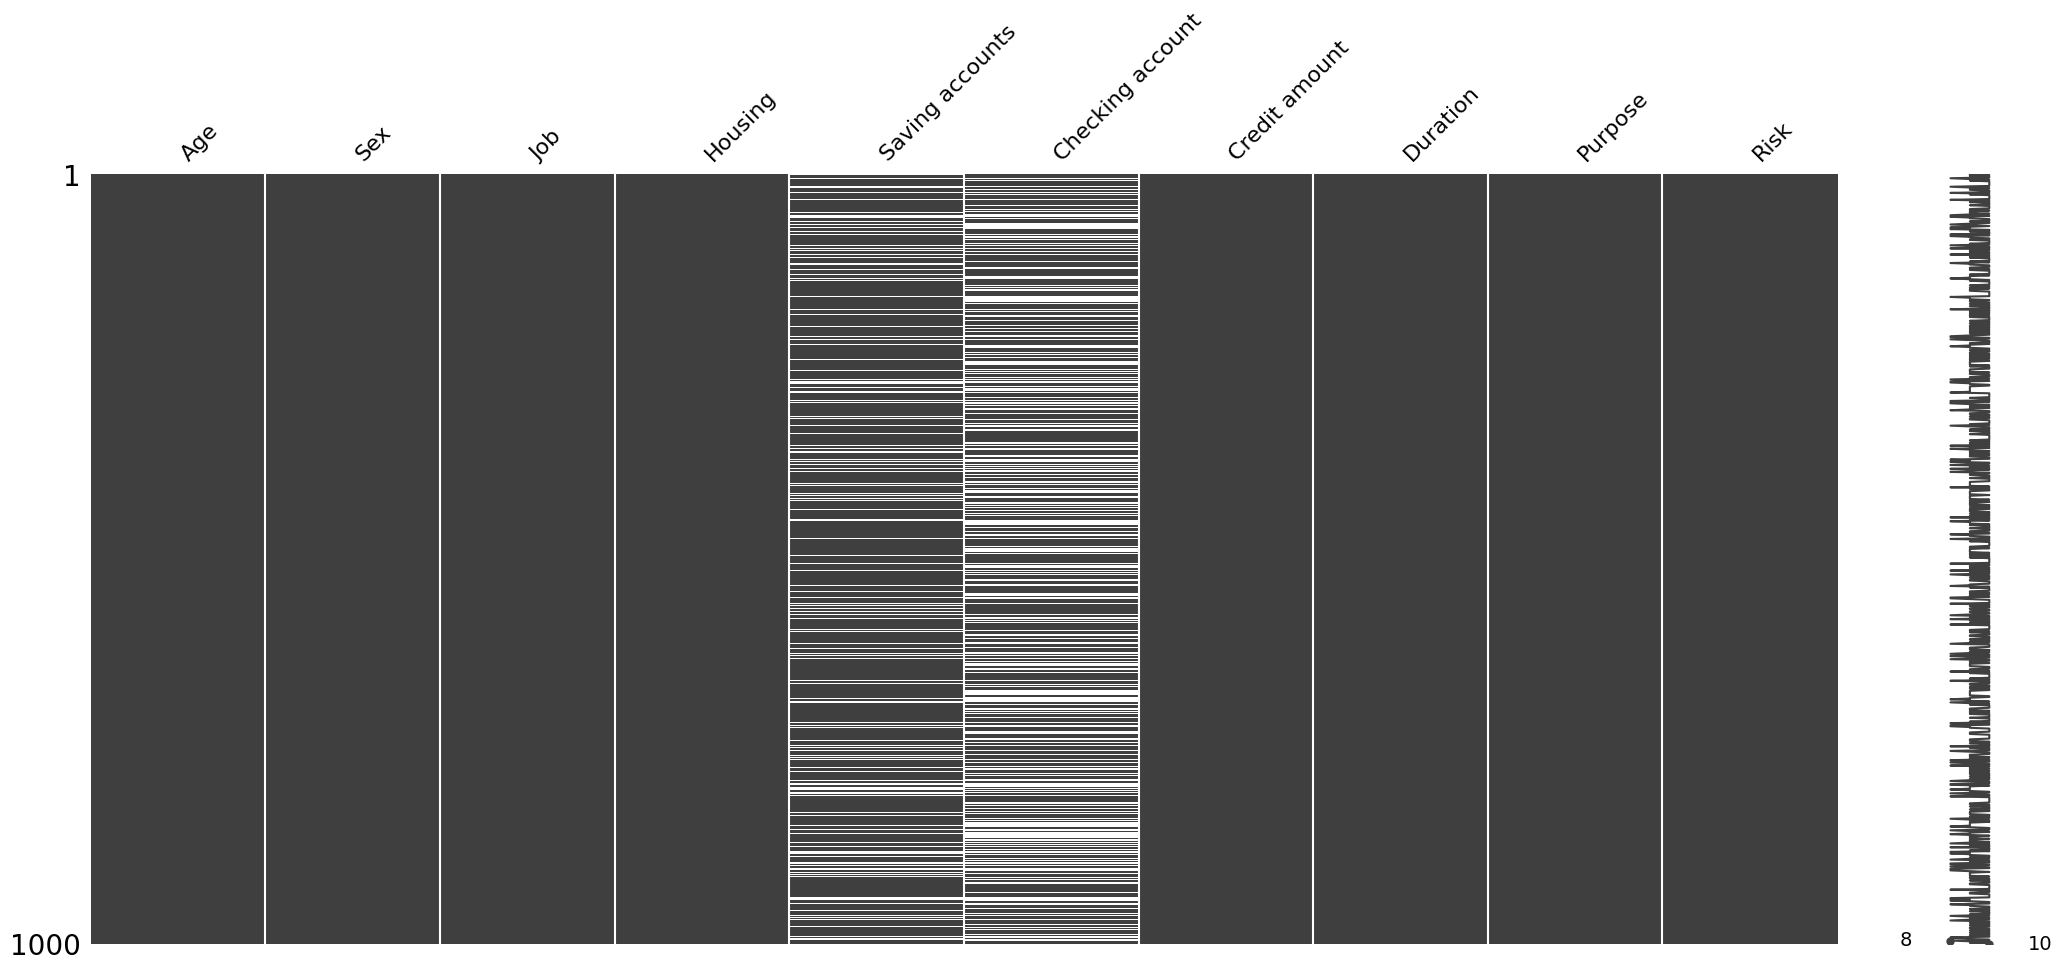

In [54]:
msno.matrix(df)

In [55]:
def missing_values_table(dataframe, na_name=False):
    na_columns = [col for col in dataframe.columns if dataframe[col].isnull().sum() > 0]
    n_miss = dataframe[na_columns].isnull().sum().sort_values(ascending=False)
    ratio = (dataframe[na_columns].isnull().sum() / dataframe.shape[0] * 100).sort_values(ascending=False)
    missing_df = pd.concat([n_miss, np.round(ratio, 2)], axis=1, keys=['n_miss', 'ratio'])
    print(missing_df, end="\n")
    if na_name:
        return na_columns

missing_values_table(df)

                  n_miss  ratio
Checking account     394   39.4
Saving accounts      183   18.3


Check Outliers¶


In [56]:
# Lets analyze outliers:

def outlier_thresholds(dataframe, col_name, q1=0.05, q3=0.95):
    quartile1 = dataframe[col_name].quantile(q1)
    quartile3 = dataframe[col_name].quantile(q3)
    interquantile_range = quartile3 - quartile1
    up_limit = quartile3 + 1.5 * interquantile_range
    low_limit = quartile1 - 1.5 * interquantile_range
    return low_limit, up_limit

for col in num_cols:
    low_limit, up_limit = outlier_thresholds(df, col)
    print(low_limit, up_limit)

-35.0 117.0
-11971.674999999992 21843.32499999999
-57.0 111.0


Visualizing Categorical Variables

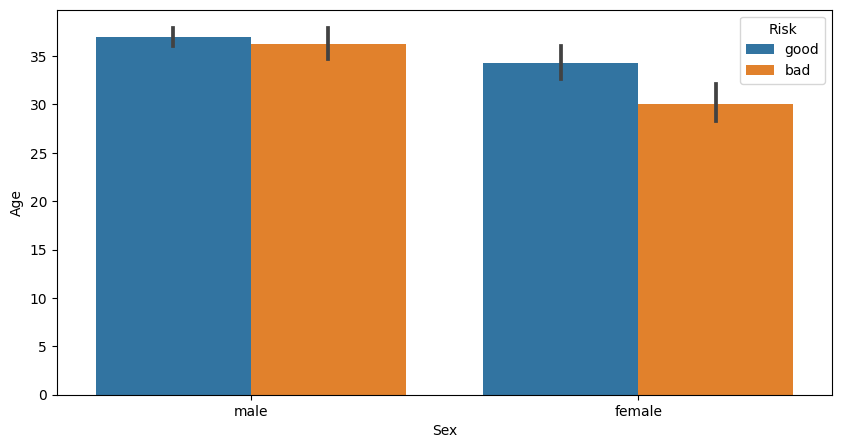

In [57]:
f, ax = plt.subplots(1, 1, figsize=(10, 5))
ax = sns.barplot(x='Sex', y='Age', hue='Risk', data=df)

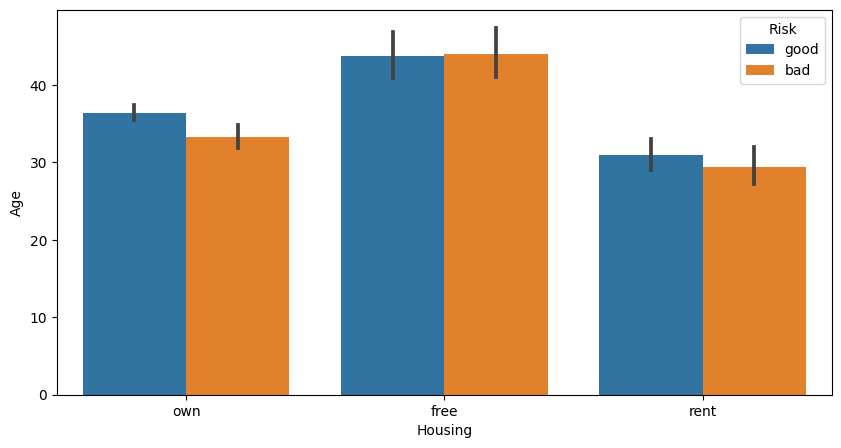

In [58]:
f, ax = plt.subplots(1, 1, figsize=(10, 5))
ax = sns.barplot(x='Housing', y='Age', hue='Risk', data=df)

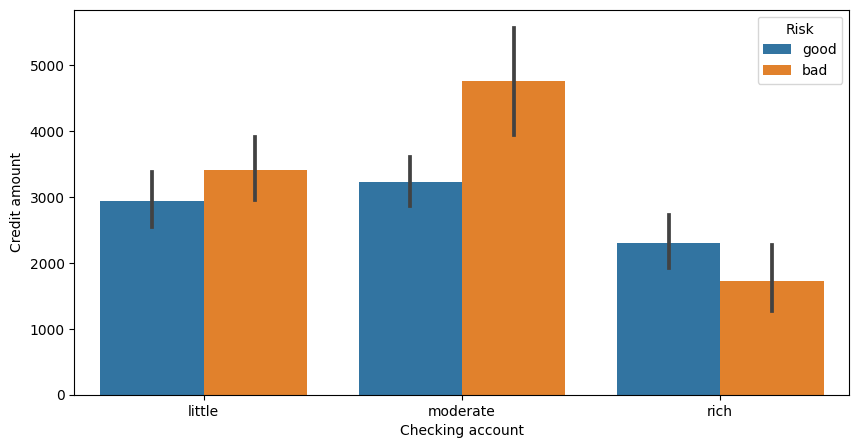

In [59]:
f, ax = plt.subplots(1, 1, figsize=(10, 5))
ax = sns.barplot(x='Checking account', y='Credit amount', hue='Risk', data=df)

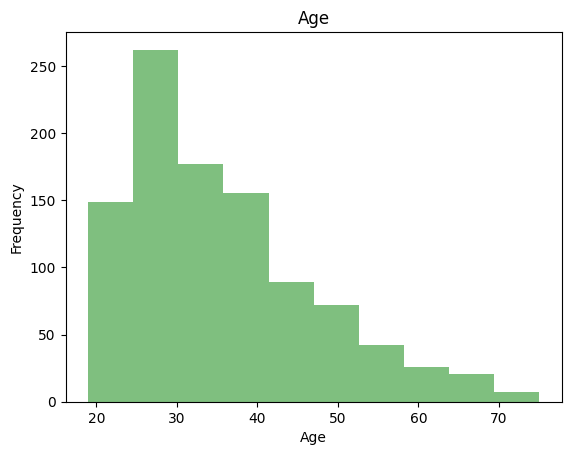

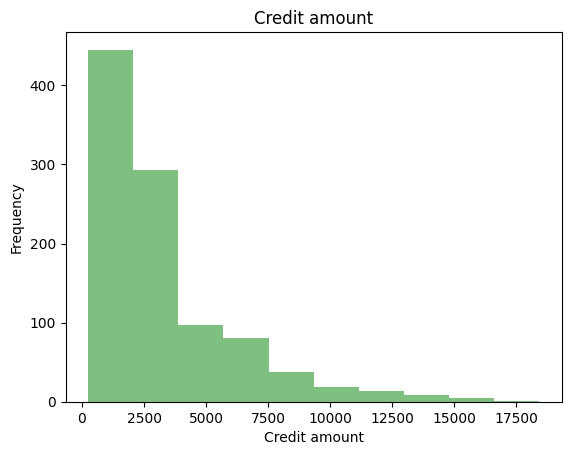

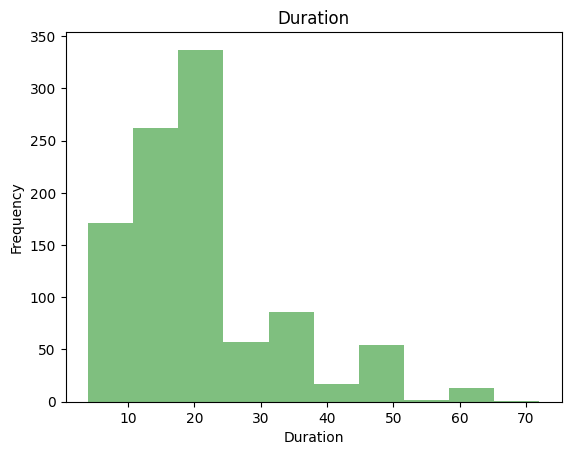

In [60]:
def hist_for_nums(data, numeric_cols):
    for col in numeric_cols:
        data[col].plot.hist(alpha=0.5, color='g')
        plt.xlabel(col)
        plt.title(col)
        plt.show()
hist_for_nums(df, num_cols)

In [61]:
def label_encoder(dataframe, binary_col):
    labelencoder = LabelEncoder()
    dataframe[binary_col] = labelencoder.fit_transform(dataframe[binary_col])
    return dataframe

binary_cols = [col for col in df.columns if df[col].dtype not in [int, float]
               and df[col].nunique() == 2]

for col in binary_cols:
    label_encoder(df, col)

In [63]:
def one_hot_encoder(dataframe, categorical_cols, drop_first=True):
    dataframe = pd.get_dummies(dataframe, columns=categorical_cols, drop_first=drop_first)
    return dataframe


# cat_cols, num_cols, cat_but_car = grab_col_names(df)

ohe_cols = [col for col in df.columns if 10 >= df[col].nunique() > 2]

df = one_hot_encoder(df, ohe_cols)

In [64]:
df

,Age,Sex,Credit amount,Duration,Risk,Job_1,Job_2,Job_3,Housing_own,Housing_rent,Saving accounts_moderate,Saving accounts_quite rich,Saving accounts_rich,Checking account_moderate,Checking account_rich,Purpose_car,Purpose_domestic appliances,Purpose_education,Purpose_furniture/equipment,Purpose_radio/TV,Purpose_repairs,Purpose_vacation/others
0,67,1,1169,6,1,0,1,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0
1,22,0,5951,48,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0
2,49,1,2096,12,1,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0
3,45,1,7882,42,1,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
4,53,1,4870,24,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,31,0,1736,12,1,1,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0
996,40,1,3857,30,1,0,0,1,1,0,0,0,0,0,0,1,0,0,0,0,0,0
997,38,1,804,12,1,0,1,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0
998,23,1,1845,45,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0


In [65]:
 cat_cols, num_cols, cat_but_car = grab_col_names(df, cat_th=5, car_th=20)


Observations: 1000
Variables: 22
cat_cols: 19
num_cols: 3
cat_but_car: 0
num_but_cat: 19


Analysis of Correlation¶


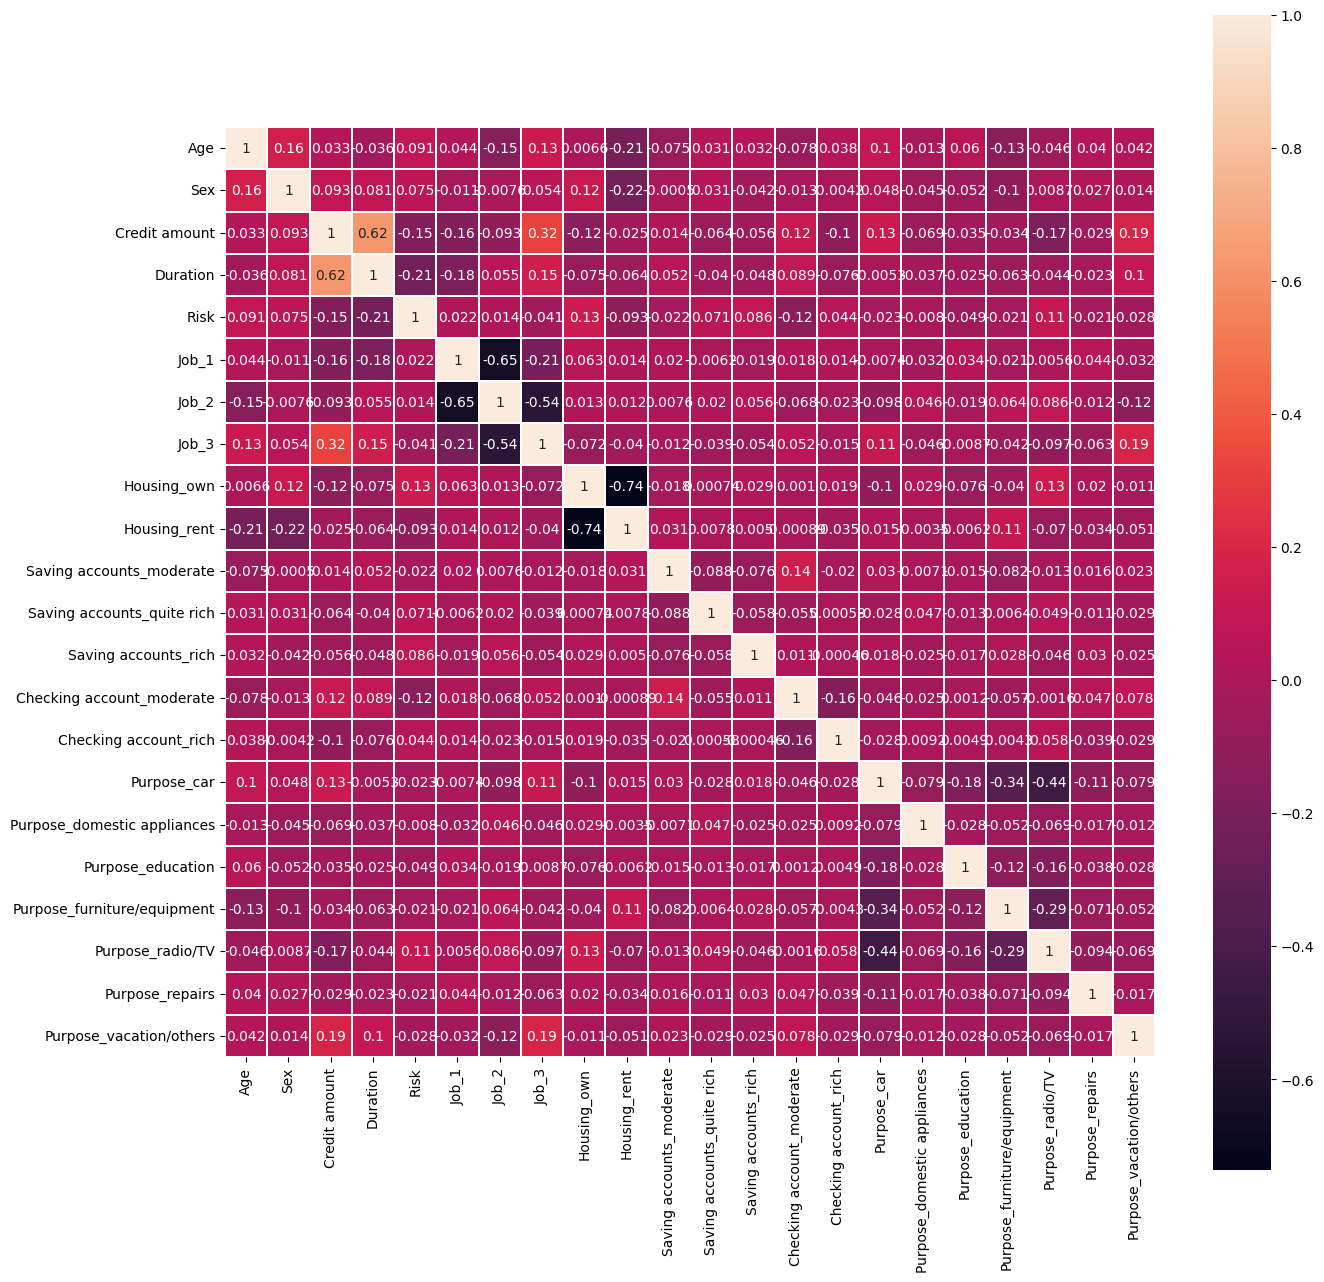

In [66]:
plt.figure(figsize=(15,15))
sns.heatmap(df.astype(float).corr(),linewidths=0.1,vmax=1.0, 
            square=True,  linecolor='white', annot=True)
plt.show()

MACHINE LEARNING MODEL¶


In [67]:
# X and y variables:

X = df.drop('Risk', axis=1)
y = df["Risk"]

In [68]:
X_scaled = StandardScaler().fit_transform(df[num_cols])
df[num_cols] = pd.DataFrame(X_scaled, columns=df[num_cols].columns)

In [70]:
# KNN
knn_model = KNeighborsClassifier().fit(X,y)
# y_pred for confusion matrix:
y_pred = knn_model.predict(X)

# y_prob for AUC:
y_prob = knn_model.predict_proba(X)[:,1]
print(classification_report(y, y_pred))

              precision    recall  f1-score   support

           0       0.61      0.39      0.48       300
           1       0.77      0.89      0.83       700

    accuracy                           0.74      1000
   macro avg       0.69      0.64      0.65      1000
weighted avg       0.73      0.74      0.73      1000



In [71]:
roc_auc_score(y,y_prob)

0.7932547619047617

In [72]:
cv_results = cross_validate(knn_model, X, y, cv=5, scoring=["accuracy", "f1", "roc_auc"])
print("Mean Test Accuracy: ",cv_results["test_accuracy"].mean())
print("Mean Test f1 score: ",cv_results["test_f1"].mean())
print("Mean Test roc_auc: ",cv_results["test_roc_auc"].mean())

Mean Test Accuracy:  0.655
Mean Test f1 score:  0.7731923090749285
Mean Test roc_auc:  0.5563690476190477


In [73]:
knn_model = KNeighborsClassifier()
knn_model.get_params()

{'algorithm': 'auto',
 'leaf_size': 30,
 'metric': 'minkowski',
 'metric_params': None,
 'n_jobs': None,
 'n_neighbors': 5,
 'p': 2,
 'weights': 'uniform'}

In [74]:
knn_params = {"n_neighbors":range(2,50)}
knn_gs_best = GridSearchCV(knn_model, knn_params, cv=5, n_jobs=-1, verbose=1).fit(X,y)
knn_gs_best.best_params_

Fitting 5 folds for each of 48 candidates, totalling 240 fits


{'n_neighbors': 35}

In [75]:
knn_final = knn_model.set_params(**knn_gs_best.best_params_).fit(X,y)

In [76]:
cv_results = cross_validate(knn_model, X, y, cv=5, scoring=["accuracy", "f1", "roc_auc"])
print("Mean Test Accuracy: ",cv_results["test_accuracy"].mean())
print("Mean Test f1 score: ",cv_results["test_f1"].mean())
print("Mean Test roc_auc: ",cv_results["test_roc_auc"].mean())

Mean Test Accuracy:  0.708
Mean Test f1 score:  0.8243297386848655
Mean Test roc_auc:  0.5739047619047619


In [86]:
from importlib import reload 
import predictor_class as pc
reload(pc)

<module 'predictor_class' from '/Users/ali/Desktop/credit/d3/predictor_class.py'>

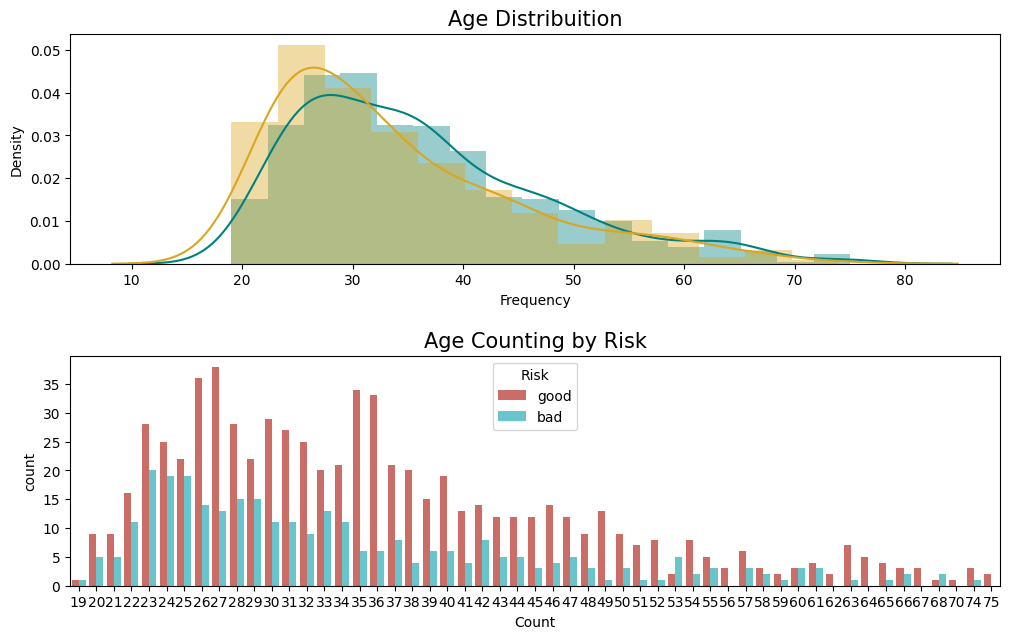

In [88]:
(
    pc.MLCredit()

        .plot_dist(col='Age')
)

In [1]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import (accuracy_score, roc_auc_score, matthews_corrcoef,
                             recall_score, precision_score, confusion_matrix)
import tensorflow as tf
# from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import Dense
# from tensorflow.keras.optimizers import Adam

TypeError: Descriptors cannot not be created directly.
If this call came from a _pb2.py file, your generated code is out of date and must be regenerated with protoc >= 3.19.0.
If you cannot immediately regenerate your protos, some other possible workarounds are:
 1. Downgrade the protobuf package to 3.20.x or lower.
 2. Set PROTOCOL_BUFFERS_PYTHON_IMPLEMENTATION=python (but this will use pure-Python parsing and will be much slower).

More information: https://developers.google.com/protocol-buffers/docs/news/2022-05-06#python-updates

In [3]:
import pandas as pd
df = pd.read_csv("./german_credit_data 2.csv", index_col=0)

,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose,Risk
0,67,male,2,own,no_info,little,1169,6,radio/TV,good
1,22,female,2,own,little,moderate,5951,48,radio/TV,bad
2,49,male,1,own,little,no_info,2096,12,education,good
3,45,male,2,free,little,little,7882,42,furniture/equipment,good
4,53,male,2,free,little,little,4870,24,car,bad
...,...,...,...,...,...,...,...,...,...,...
995,31,female,1,own,little,no_info,1736,12,furniture/equipment,good
996,40,male,3,own,little,little,3857,30,car,good
997,38,male,2,own,little,no_info,804,12,radio/TV,good
998,23,male,2,free,little,little,1845,45,radio/TV,bad


/opt/homebrew/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


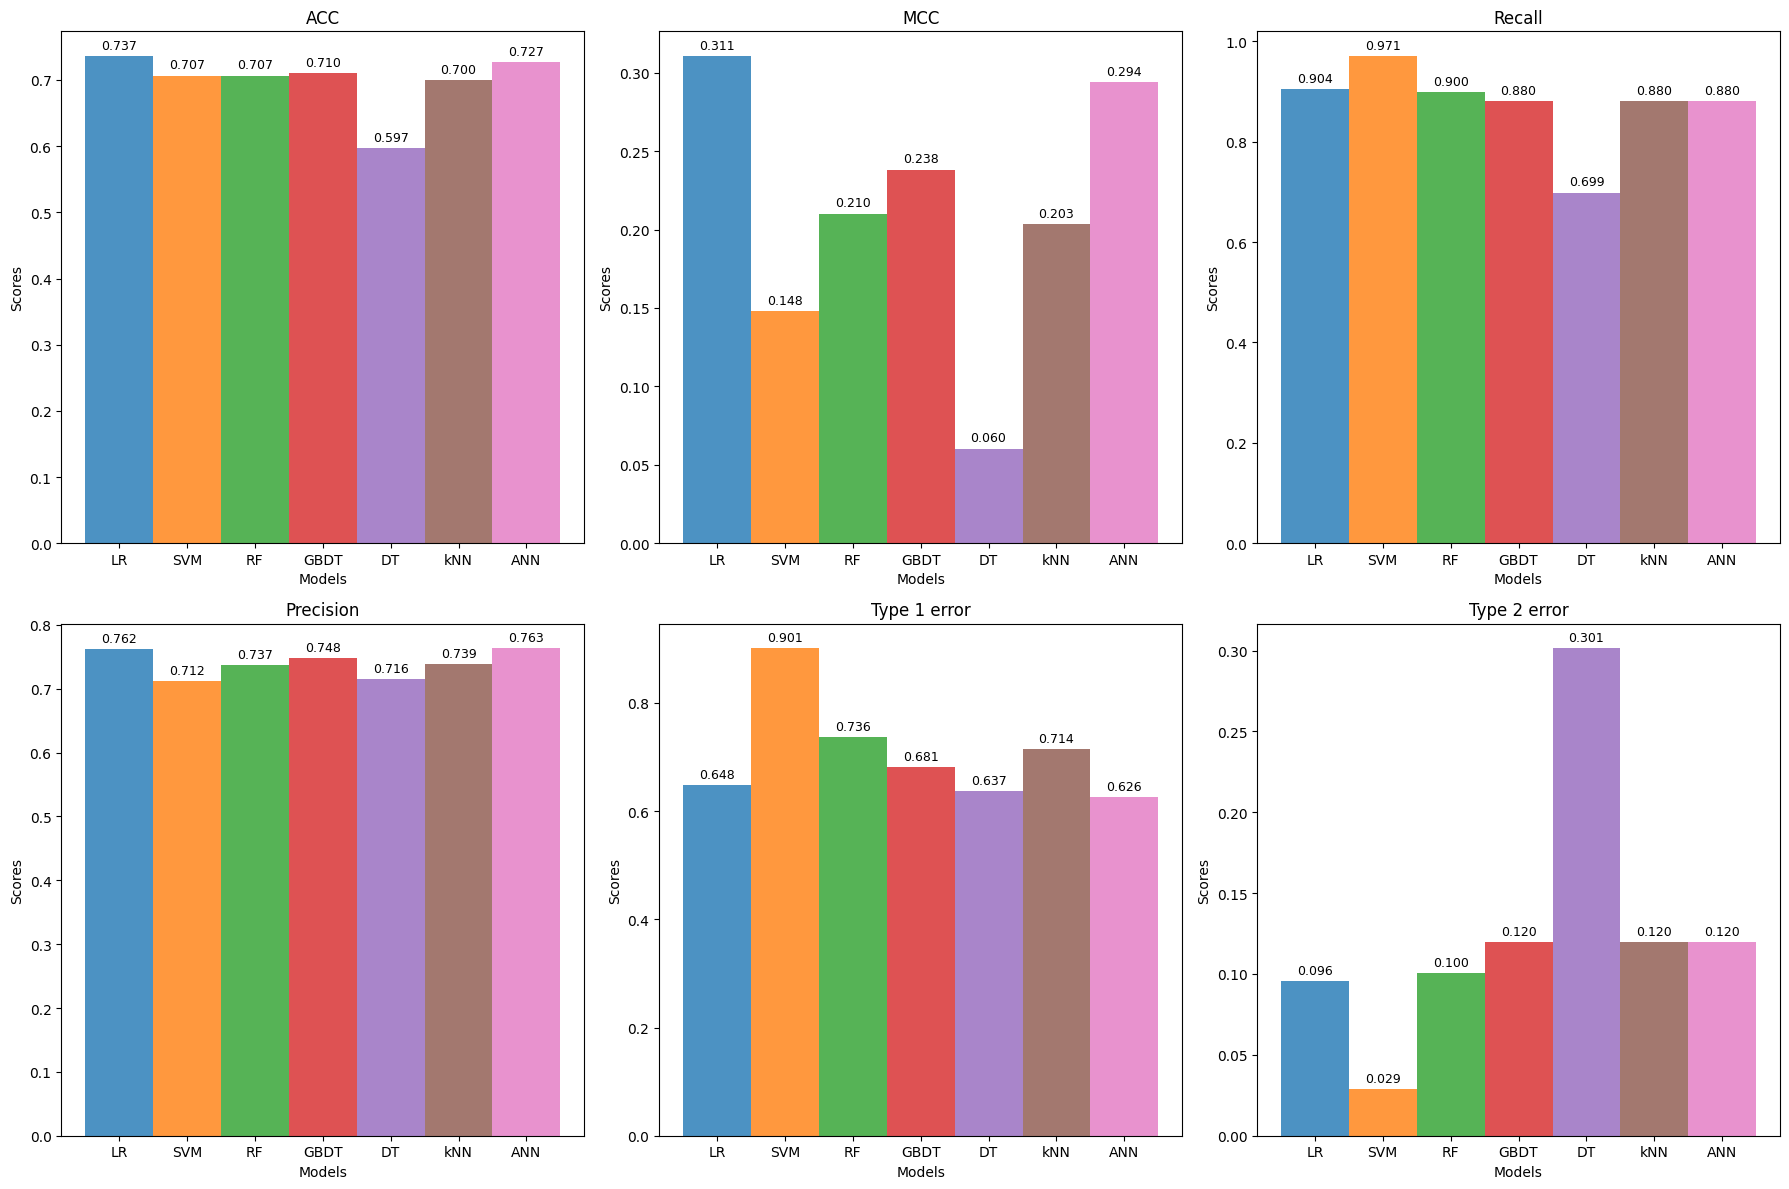

In [19]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.cluster import KMeans
from sklearn.metrics import (accuracy_score, roc_auc_score, matthews_corrcoef,
                             recall_score, precision_score, confusion_matrix)
from sklearn.model_selection import train_test_split

df.fillna("no_info", inplace=True)
# Load your dataset
df = pd.read_csv("./german_credit_data 2.csv", index_col=0)

# Preprocess your data
X = df.drop("Risk", axis=1)
y = df["Risk"]

le = LabelEncoder()
y_encoded = le.fit_transform(y)

# Define the columns to be standardized and one-hot encoded
num_features = ['Age', 'Credit amount', 'Duration']
cat_features = ['Job', 'Sex', 'Housing', 'Saving accounts', 'Checking account', 'Purpose']

# Create a column transformer with the respective transformers
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), num_features),
        ('cat', OneHotEncoder(), cat_features)
    ])

# Fit and transform the data
X_processed = preprocessor.fit_transform(X)

kmeans = KMeans(n_clusters=30, random_state=42)
X_clustered = kmeans.fit_transform(X_processed)

# Split your data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X_clustered, y_encoded, test_size=0.3, random_state=42)
# X_train, X_test, y_train, y_test = train_test_split(X_processed, y_encoded, test_size=0.3, random_state=42)

# Define the models
models = {
    "LR": LogisticRegression(),
    "SVM": SVC(probability=True),
    "RF": RandomForestClassifier(),
    "GBDT": GradientBoostingClassifier(),
    "DT": DecisionTreeClassifier(),
    "kNN": KNeighborsClassifier(),
    "ANN": MLPClassifier()
}

# Train and evaluate the models
results = []

for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1]
    acc = accuracy_score(y_test, y_pred)
    roc = roc_auc_score(y_test, y_proba)
    mcc = matthews_corrcoef(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    type_1_error = fp / (fp + tn)
    type_2_error = fn / (fn + tp)
    results.append([name, acc, mcc, recall, precision, type_1_error, type_2_error])

# Display the results in a DataFrame
metrics = ["ACC", "MCC", "Recall", "Precision", "Type 1 error", "Type 2 error"]

results_df = pd.DataFrame(results, columns=["Model", "ACC", "MCC", "Recall", "Precision", "Type 1 error", "Type 2 error"])

# Function to add labels on the bars
def add_labels(ax, bars):
    for bar in bars:
        height = bar.get_height()
        ax.annotate(
            '{:.3f}'.format(height),
            xy=(bar.get_x() + bar.get_width() / 2, height),
            xytext=(0, 3),  # 3 points vertical offset
            textcoords="offset points",
            ha='center',
            va='bottom',
            fontsize=9
        )

# Plot the evaluation metrics
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.ravel()
bar_width = 0.1
opacity = 0.8

for idx, metric in enumerate(metrics):
    ax = axes[idx]
    bars = []
    for i, (name, row) in enumerate(results_df.set_index("Model").iterrows()):
        bar = ax.bar(i * bar_width, row[metric], bar_width, alpha=opacity, label=name)
        bars.append(bar[0])
    
    add_labels(ax, bars)
    ax.set_xlabel('Models')
    ax.set_ylabel('Scores')
    ax.set_title(metric)
    ax.set_xticks([i * bar_width for i in range(len(results_df))])
    ax.set_xticklabels(results_df['Model'])
    # ax.legend()

plt.tight_layout()
plt.show()